# Derivatives Hedging

In this case study we implement Reinforcement learning-based hedging strategy
adopting the ideas presented in the paper ‘_Deep Hedging_’ (https://arxiv.org/abs/
1802.03042) by _Hans Bühler, Lukas Gonon, Josef Teichmann, Ben Wood_. 

We will
build an optimal hedging strategy for call options by minimizing the risk adjusted
PnL of a hedging. 

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Generating the Data](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Plot Paths](#2.1)    
* [4.Evaluate Algorithms and Models](#4)        
    * [4.1. Agent Script](#4.1)
    * [4.3. Training Data](#4.2)       
* [5.Testing Data](#5)   
    * [5.1. Helper Functions For comparison against Black Scholes](#5.1) 
    * [5.2. Comparison between Black Scholes and RL](#5.2)

<a id='0'></a>
# 1. Problem Definition

In the Reinforcement Learning based framework for this case study, the algorithm decides the best hedging strategy for call options from the market prices of the underlying asset based on direct policy search reinforcement learning. 

The key components of the Reinforcement Learning framework used for this case study are described below:

* Agent: Trader or a trading agent
* Action: Hedging strategy (i.e. δ1, δ2 . . , δT)
* Reward function: CVaR is used as the reward function for this case study. This is a convex function and is minimized during the model training.

* State: State is the representation of the current market state and relevant product state variables. The state represent the model inputs which are Stock Price Path
(i.e. S1, S2 . . , ST), strike and risk aversion parameter(α)

* Environment: Stock exchange or the stock market.



<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy.stats as stats
import seaborn as sns
# from IPython.core.debugger import set_trace

#Import Model Packages for reinforcement learning
from keras import layers, models
from keras import backend as K
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + tf.keras.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    tf.device(logical_gpus[0].name)
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

<a id='1.2'></a>
## 2.2. Generating the Data 

The function below generates the monte-carlo paths for the stock price and get the option price on each of the monte-carlo path.

### Black-Sholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$


In [3]:
def monte_carlo_paths(S_0, time_to_expiry, sigma, drift, seed, n_sims, n_timesteps):
    """
    Create random paths of a underlying following a browian geometric motion
    
    input:
    
    S_0 = Spot at t_0
    time_to_experiy = end of the timeseries (last observed time)
    sigma = the volatiltiy (sigma in the geometric brownian motion)
    drift = drift of the process
    n_sims = number of paths to generate
    n_timesteps = numbers of aquidistant time steps 
    
    return:
    
    a (n_timesteps x n_sims x 1) matrix
    """
    if seed > 0:
            np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, n_timesteps)
    S = S_0
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    r = drift
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)*stdnorm_random_variates), axis=1)
    return np.reshape(np.transpose(np.c_[np.ones(n_sims)*S_0, S_T]), (n_timesteps+1, n_sims, 1))

In [4]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed = 42
n_sims = 50000

In [5]:
# Train the model on the path of the risk neutral measure
paths_train = monte_carlo_paths(S_0, T, vol, r, seed, n_sims, timesteps)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Plot Paths

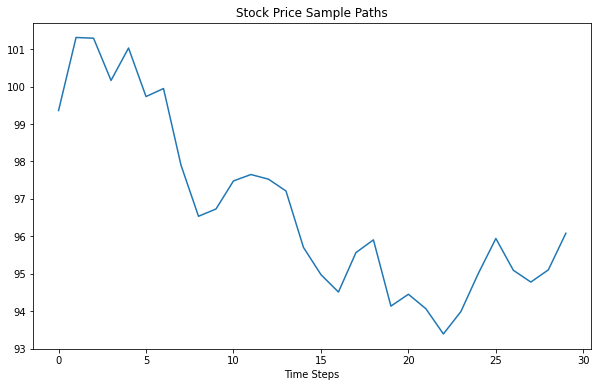

In [6]:
#Plot Paths for one simulation
plt.figure(figsize=(10,6))
plt.plot(paths_train[1:31,1])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


<a id='4'></a>
# 4. Evaluate Algorithms and Models

The approach used in the case study is Policy Gradient which is a type of Direct Policy Search (or policy-based) algorithm. In this approach we use LSTM model to map the state to action. 

<a id='4.1'></a>
## 4.1. Policy Gradient script
In this step we implement in the RL “Agent” class. Agent holds the variables and member functions that perform the training. An
object of the “Agent” class is created using the training phase and is used for training
the model. After sufficient number of iterations policy
gradient model is generated.
The “class” consists of two modules:

* Constructor
* Function execute_graph_batchwise

In [32]:
class Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='model'):
        tf.reset_default_graph()
        self.batch_size = batch_size #NUmber of options in a batch
        self.S_t_input = tf.placeholder(tf.float32, [time_steps, batch_size, features]) #Spot
        self.K = tf.placeholder(tf.float32, batch_size) #Strike 
        self.alpha = tf.placeholder(tf.float32) #alpha for cVaR

        S_T = self.S_t_input[-1,:,0] #Spot at time T
        dS = self.S_t_input[1:, :, 0] - self.S_t_input[0:-1, :, 0] # Change in the Spot price
        #dS = tf.reshape(dS, (time_steps, batch_size))

        #Prepare S_t for the use in the RNN remove the last time step (at T the portfolio is zero)
        S_t = tf.unstack(self.S_t_input[:-1, :,:], axis=0)

        # Build the lstm
        # lstm = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(n) for n in nodes])
        lstm = tf.keras.layers.StackedRNNCells([tf.nn.rnn_cell.LSTMCell(n) for n in nodes])

        #So the state is a convenient tensor that holds the last actual RNN state, ignoring the zeros. 
        #The strategy tensor holds the outputs of all cells, so it doesn't ignore the zeros. 
        # self.strategy, state = tf.nn.static_rnn(lstm, S_t, initial_state=lstm.zero_state(batch_size, tf.float32), \
        self.strategy, state = tf.nn.static_rnn(lstm, S_t, initial_state=None, \
                                                dtype=tf.float32)

        self.strategy = tf.reshape(self.strategy, (time_steps-1, batch_size))
        self.option = tf.maximum(S_T-self.K, 0)

        self.Hedging_PnL = - self.option + tf.reduce_sum(dS*self.strategy, axis=0)
        self.Hedging_PnL_Paths = - self.option + dS*self.strategy
        # Calculate the CVaR for a given confidence level alpha
        # Take the 1-alpha largest losses (top 1-alpha negative PnLs) and calculate the mean
        CVaR, idx = tf.nn.top_k(-self.Hedging_PnL, tf.cast((1-self.alpha)*batch_size, tf.int32))
        CVaR = tf.reduce_mean(CVaR)
        self.train = tf.train.AdamOptimizer().minimize(CVaR)
        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, strikes, riskaversion, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the hedging Pnl for each batch      
            pnls = []
            strategies = []            
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, hedging PnL and strategy using the inputs 
                    _, pnl, strategy = sess.run([self.train, self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                          self.K : strikes[indices],
                                                                                          self.alpha: riskaversion})
                else:
                    pnl, strategy = sess.run([self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                self.K : strikes[indices],
                                                                                self.alpha: riskaversion})
                pnls.append(pnl)
                strategies.append(strategy)
            #Calculate the option prive given the risk aversion level alpha
            #set_trace()
            CVaR = np.mean(-np.sort(np.concatenate(pnls))[:int((1-riskaversion)*sample_size)])
            #set_trace()
            if train_flag:
                if epoch % 10 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'CVaR', CVaR)
                    #Saving the model
                    self.saver.save(sess, "model.ckpt")
        self.saver.save(sess, "model.ckpt")
        return CVaR, np.concatenate(pnls), np.concatenate(strategies,axis=1)
    
    def training(self, paths, strikes, riskaversion, epochs, session, init=True):
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, strikes, riskaversion, session, epochs, train_flag=True)
        
    def predict(self, paths, strikes, riskaversion, session):
        return self._execute_graph_batchwise(paths, strikes, riskaversion,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

<a id='4.2'></a>
## 4.2. Training the data

We will proceed to train the data, based on our policy based model. This will provide us with the strategy, based on the simulated price of the stock prices at the end of the day. 

Steps: 
* Define the risk aversion parameter for cVaR, number of features, strike and define the batch size with which the neural network will be trained.
* Instantiate the Policy Gradient Agent which has the RNN based policy with the loss function or the reward function based on the cVaR reward
* The Training data is the Monte-Carlo path generated in the previous step. 
* We can start to iterate through the batches and the strategy is based on the policy that is the output of the LSTM based network. 
* The trained model is saved


In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    tf.device(logical_gpus[0].name)
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [33]:
batch_size = 1000 
features = 1 
K = 100
alpha = 0.50 #risk aversion parameter for cVaR
epoch = 100 #It is set to 100, but should ideally be a high number 
model_1 = Agent(paths_train.shape[0], batch_size, features, name='rnn_final')

In [10]:
# Training the model takes about a few minutes
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_1.training(paths_train, np.ones(paths_train.shape[1])*K, alpha, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Time elapsed: 0:00:04.841803
Epoch 0 CVaR 3.852412
Time elapsed: 0:00:18.281138
Epoch 10 CVaR 2.7268531
Time elapsed: 0:00:31.481454
Epoch 20 CVaR 2.6188514
Time elapsed: 0:00:44.645326
Epoch 30 CVaR 2.6102216
Time elapsed: 0:00:57.809711
Epoch 40 CVaR 2.593789
Time elapsed: 0:01:11.193122
Epoch 50 CVaR 2.5923634
Time elapsed: 0:01:24.977774
Epoch 60 CVaR 2.6553264
Time elapsed: 0:01:38.392218
Epoch 70 CVaR 2.58786
Time elapsed: 0:01:51.815524
Epoch 80 CVaR 2.5851004
Time elapsed: 0:02:05.154919
Epoch 90 CVaR 2.6022213
Training finished, Time elapsed: 0:02:17.948008


<a id='5'></a>
# 5. Testing the Data 
In the testing step, we will com‐
pare the effectiveness of the hedging strategy and compare it to the delta hedging
strategy based on the Black Scholes model. We first define the helper functions fol‐
lowed by the results comparison.

<a id='5.1'></a>
## 5.1. Helper Functions for Comparison against Black Scholes

<a id='5.1.1'></a>
### 5.1.1 Black Scholes Price and Delta

In [11]:
def BS_d1(S, dt, r, sigma, K):
    return (np.log(S/K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))

def BlackScholes_price(S, T, r, sigma, K, t=0):
    dt = T-t
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BS_d1(S, dt, r, sigma, K)
    d2 = d1 - sigma*np.sqrt(dt)
    return S*Phi(d1) - K*np.exp(-r*dt)*Phi(d2)

def BS_delta(S, T, r, sigma, K, t=0):
    dt = T-t
    d1 = BS_d1(S, dt, r, sigma, K)
    Phi = stats.norm(loc=0, scale=1).cdf
    return Phi(d1)

<a id='5.1.2'></a>
### 5.1.2 Test Results and Plotting

In [12]:
def test_hedging_strategy(deltas, paths, K, price, alpha, output=True):
    S_returns = paths[1:,:,0]-paths[:-1,:,0]
    hedge_pnl = np.sum(deltas * S_returns, axis=0)
    option_payoff = np.maximum(paths[-1,:,0] - K, 0)
    replication_portfolio_pnls = -option_payoff + hedge_pnl + price
    mean_pnl = np.mean(replication_portfolio_pnls)
    cvar_pnl = -np.mean(np.sort(replication_portfolio_pnls)[:int((1-alpha)*replication_portfolio_pnls.shape[0])])
    if output:
        plt.hist(replication_portfolio_pnls)
        print('BS price at t0:', price)
        print('Mean Hedging PnL:', mean_pnl)
        print('CVaR Hedging PnL:', cvar_pnl)
    return (mean_pnl, cvar_pnl, hedge_pnl, replication_portfolio_pnls, deltas)

def plot_deltas(paths, deltas_bs, deltas_rnn, times=[0, 1, 5, 10, 15, 29]):
    fig = plt.figure(figsize=(10,6))
    for i, t in enumerate(times):
        plt.subplot(2,3,i+1)
        xs =  paths[t,:,0]
        ys_bs = deltas_bs[t,:]
        ys_rnn = deltas_rnn[t,:]
        df = pd.DataFrame([xs, ys_bs, ys_rnn]).T
        #df = df.groupby(0, as_index=False).agg({1:np.mean,
        #                                          2: np.mean})
        plt.plot(df[0], df[1], df[0], df[2], linestyle='', marker='x' )
        plt.legend(['BS delta', 'RNN Delta'])
        plt.title('Delta at Time %i' % t)
        plt.xlabel('Spot')
        plt.ylabel('$\Delta$')
    plt.tight_layout()
    
def plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn):
    fig = plt.figure(figsize=(10,6))
    dic = {'name': ['Black-Scholes']*len(portfolio_pnl_bs) + ['RNN-LSTM-v1']*len(portfolio_pnl_rnn), \
        'values': np.concatenate((portfolio_pnl_bs, portfolio_pnl_rnn), axis=0)}
    dat=pd.DataFrame(data=dic)
    sns.boxplot(x='name', y='values', data=dat)
    # sns.boxplot(x=['Black-Scholes', 'RNN-LSTM-v1'], y=[portfolio_pnl_bs, portfolio_pnl_rnn])
    plt.title('Compare PnL Replication Strategy')
    plt.ylabel('PnL')

<a id='5.1.3'></a>
### 5.1.3 Hedging Error for Black Scholes Replication
Function for Black Scholes Hedge Replication

In [13]:
def black_scholes_hedge_strategy(S_0, K, r, vol, T, paths, alpha, output):
    bs_price = BlackScholes_price(S_0, T, r, vol, K, 0)
    times = np.zeros(paths.shape[0])
    times[1:] = T / (paths.shape[0]-1)
    times = np.cumsum(times)    
    bs_deltas = np.zeros((paths.shape[0]-1, paths.shape[1]))
    for i in range(paths.shape[0]-1):
        t = times[i]
        bs_deltas[i,:] = BS_delta(paths[i,:,0], T, r, vol, K, t)
    return test_hedging_strategy(bs_deltas, paths, K, bs_price, alpha, output)

<a id='5.2'></a>
## 5.2. Comparison between Black Scholes and Reinforcement Learning

<a id='5.2.1'></a>
### 5.2.1. Test at 99% CVaR

First, we compare the average PnL and the CVaR of the trading strategies assuming we can charge the Black Scholes price for the option.

For the first test set (strike 100, same drift, same vol) the results looks quite good.

In [14]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed_test = 21122017
n_sims_test = 10000

In [15]:
# Monte Carlo Path for the test set
alpha = 0.99
paths_test =  monte_carlo_paths(S_0, T, vol, r, seed_test, n_sims_test, timesteps)

In [16]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test1_results = model_1.predict(paths_test, np.ones(paths_test.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


In [17]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.0010458505607415403
CVaR Hedging PnL: 1.2447953011695536
BS price at t0: 2.302974467802428
Mean Hedging PnL: -0.0007005714424858578
CVaR Hedging PnL: 1.3239804185751292


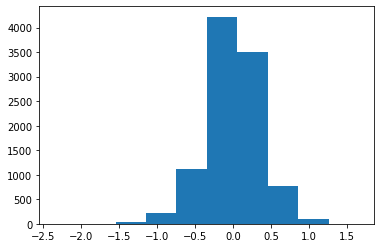

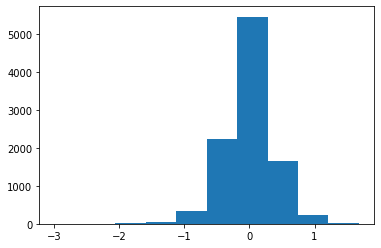

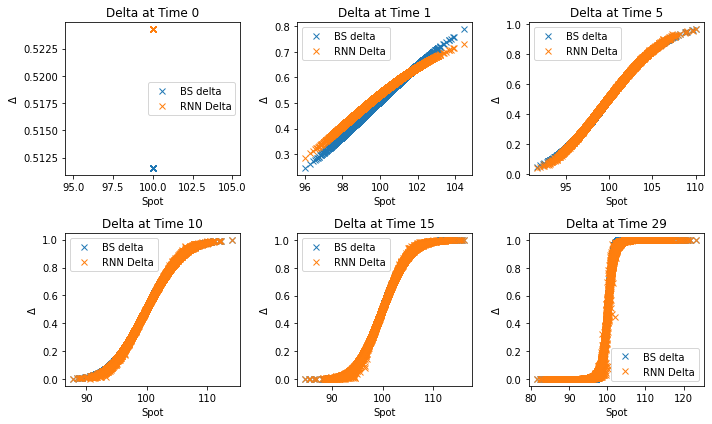

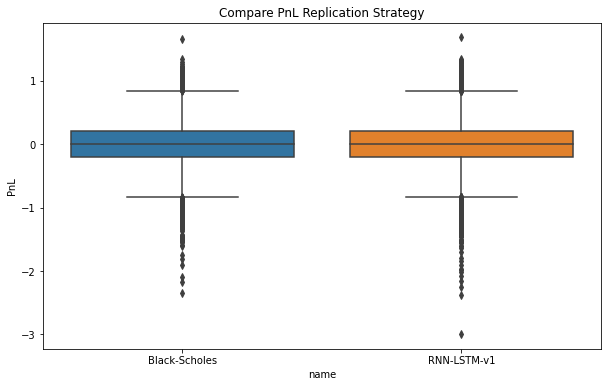

In [18]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1_results[2], paths_test, K, 2.302974467802428, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

<a id='5.2.2'></a>
### 5.2.2. Changing Moneyness

In [19]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_Moneyness = model_1.predict(paths_test, np.ones(paths_test.shape[1])*(K-10), alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 10.07339936955367
Mean Hedging PnL: 0.0007508571761945146
CVaR Hedging PnL: 0.6977526775080664
BS price at t0: 10.073
Mean Hedging PnL: -0.03734701822631514
CVaR Hedging PnL: 3.418307696041575


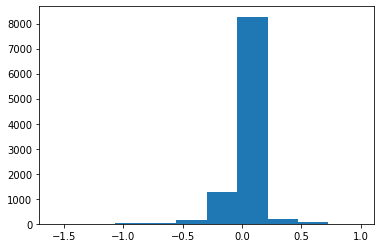

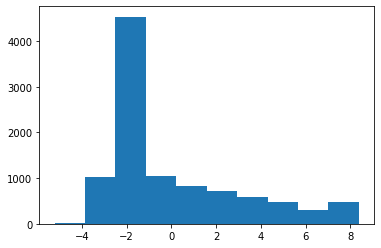

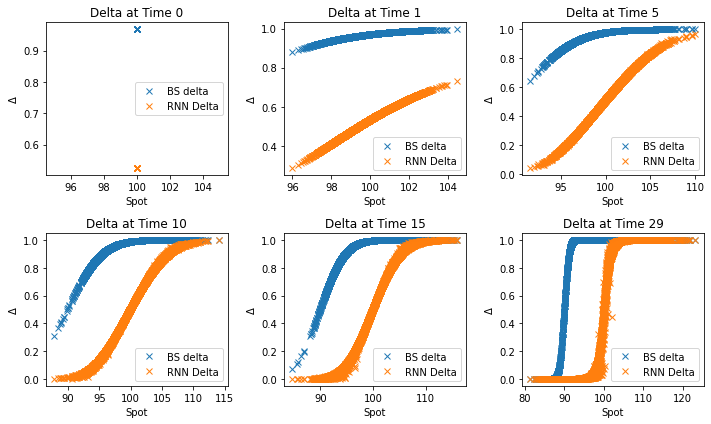

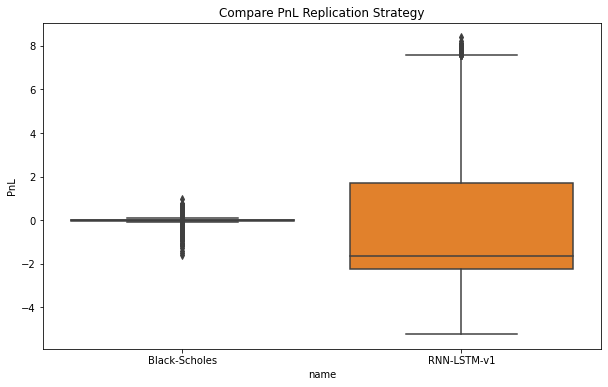

In [20]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K-10, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_Moneyness[2], paths_test, K-10, 10.073, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

<a id='5.2.3'></a>
### 5.2.3. Changing Drift

In [21]:
# Test set 2: Assume the drift of the underlying is 4% per month under the real world measure 
paths_test_drift = monte_carlo_paths(S_0, T, vol, 0.48+r, seed_test, n_sims_test, timesteps)

In [22]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_drift = model_1.predict(paths_test_drift, np.ones(paths_test_drift.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.017239029648273896
CVaR Hedging PnL: 1.2141220199385756
BS price at t0: 2.3029
Mean Hedging PnL: -0.02435955284632033
CVaR Hedging PnL: 1.3446707315265


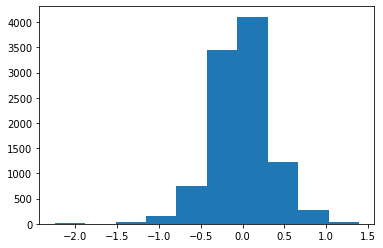

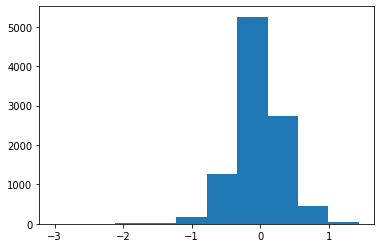

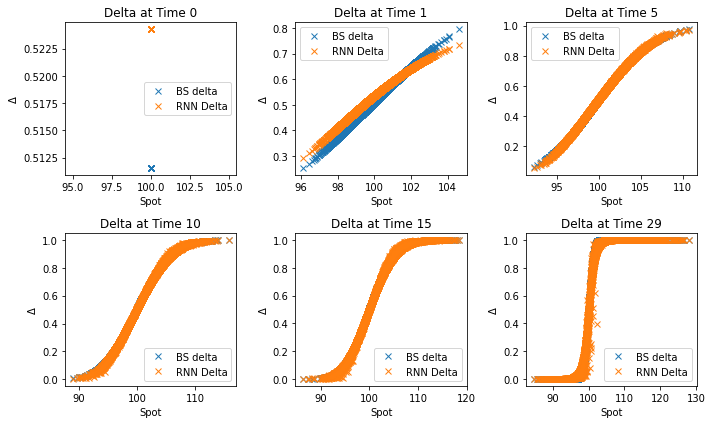

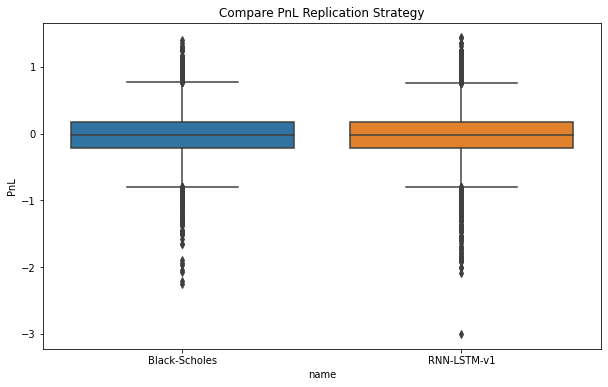

In [23]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K,r, vol, T, paths_test_drift, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_drift[2], paths_test_drift, K, 2.3029, alpha, True)
plot_deltas(paths_test_drift, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

## <a id='5.2.4'></a>
### 5.3.4. Shifted Volatility

In [24]:
# Test set 3: Assume the volatility is not constant and the realized volatility is 5% higher 
# than the implied (historical observed) one
paths_test_vol = monte_carlo_paths(S_0, T, vol+0.05, r, seed_test, n_sims_test, timesteps)

In [25]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_vol = model_1.predict(paths_test_vol, np.ones(paths_test_vol.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.5787493248269506
CVaR Hedging PnL: 2.558392282440757
BS price at t0: 2.309
Mean Hedging PnL: -0.5725554109706705
CVaR Hedging PnL: 2.7724661571918405


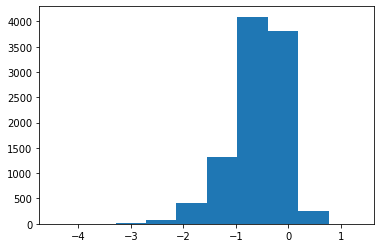

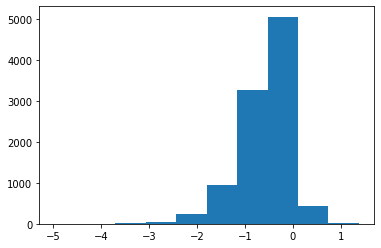

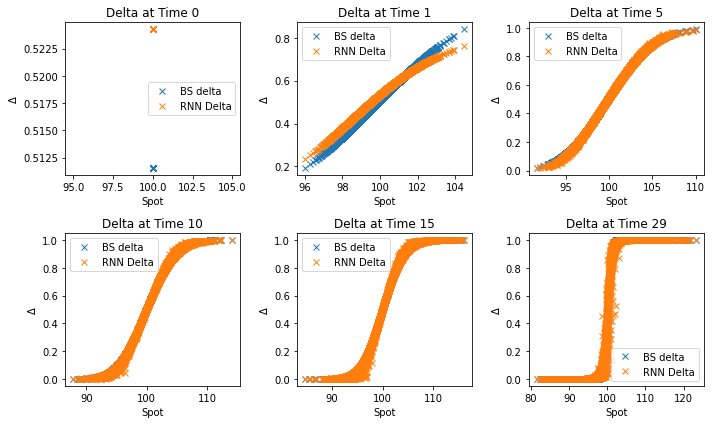

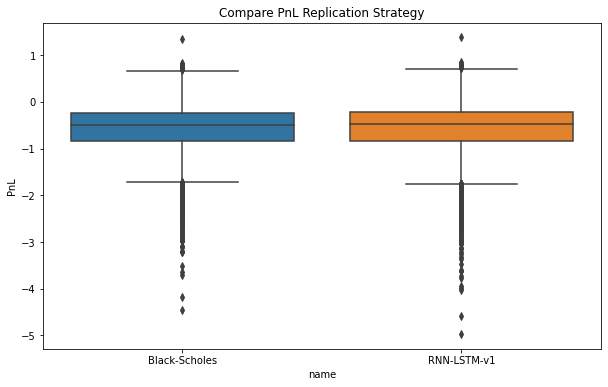

In [26]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_vol, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_vol[2], paths_test_vol, K, 2.309, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

In [27]:
deltas_rnn.shape

(30, 10000)

**Conclusion**

The Policy Gradient based model is able to learn a hedging strategy for a particular option without any assumption of the underlying stochastic process.

We compare the effectiveness of the hedging strategy and compare it to the delta hedging strategy using the Black Scholes Delta. The RL based hedging strategy quite well even when the few input parameters such as risk aversion and drifts were modified. However, RL method wasn’t able to generalize the strategy for options at different moneyness levels.  It demonstrates the fact that RL is a data intensive approach, and it is important to train the model with different cases, which becomes more important if model is intended to be used across wide variety of derivatives. As compared to Black Scholes model, there is a significant scope of improvement of the RL based models by training them using a wide variety of instruments with different hyperparameters. It would be interesting to analyze the comparison of the RL based model vs the traditional hedging models for exotic derivatives given the trade-off between these approaches.


